In [12]:
import os
import struct
import random
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
from torch.utils.data import Dataset, DataLoader
import torchvision
import array
#import datalaoder

import datetime
import time
from pathlib import Path
from typing import Dict, List, Optional, Union

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import utils as vutils

#from test import EMnistDataset
from dataset import EMnistDataset

In [13]:
!pwd

/mnt/tapioca/Workspace/hw/A4_gans


In [3]:
train_label_filepath = r'./data/EMNIST/emnist-byclass-train-labels-idx1-ubyte'
train_img_filepath = r'./data/EMNIST/emnist-byclass-train-images-idx3-ubyte'
test_label_filepath = r'./data/EMNIST/emnist-byclass-test-labels-idx1-ubyte'
test_img_filepath = r'./data/EMNIST/emnist-byclass-test-images-idx3-ubyte'

In [4]:
def show_images(real_imgs, fake_imgs: None, nrow=6, ncol=6, figsize=(5, 5), save: bool = False, show: bool = True, name=""):
    # compare and show n*m images from generator in one figure and optionally save it
    for imgs, label in zip([imgs for imgs in [real_imgs, fake_imgs] if fake_imgs is not None], ["real", "fake"]):
        imgs = imgs[:nrow * ncol]
        imgs = imgs.view(imgs.size(0), opt.channels, opt.img_size, opt.img_size)
        plt.figure(figsize=figsize)
        plt.imshow(np.transpose(vutils.make_grid(imgs, nrow=nrow, padding=2, normalize=True).cpu(), (1, 2, 0)))
        plt.axis('off')
        plt.title(name + label + " images")
        if save:
            plt.savefig(gen_img_root / (name + label + " images.png"))
        if show:
            plt.show()

In [5]:
checkpoint_root = Path("dcGAN_2")
gen_img_root = Path("dcGAN_2/images")
weights_root = Path("dcGAN_2/weights")
checkpoint_root.mkdir(exist_ok=True)
gen_img_root.mkdir(exist_ok=True)
weights_root.mkdir(exist_ok=True)

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


# %%
class Parse:
    def __init__(self) -> None:
        self.n_epochs = 200
        self.batch_size = 1024
        self.lr = 0.0002
        self.b1 = 0.5
        self.b2 = 0.999
        self.n_cpu = 8
        self.latent_dim = 100
        self.img_size = 32
        self.channels = 1
        self.sample_interval = 100


opt = Parse()

# %%
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

torch.cuda.set_device(6)
device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")
print("device", torch.cuda.current_device(), torch.cuda.get_device_name(torch.cuda.current_device()))


# %%
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = opt.img_size // 4
        self.l1 = nn.Sequential(nn.Linear(opt.latent_dim, 128 * self.init_size**2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, opt.channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(opt.channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = opt.img_size // 2**4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size**2, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity


# %%
# Loss function
adversarial_loss = nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

generator.to(device)
discriminator.to(device)

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)
# Configure data loader


# transform=transforms.Compose([transforms.ToTensor(),
#                               transforms.Normalize([0.5], [0.5]),
#                               transforms.Resize(32)])
# train_laoder = DataLoader(EMnistDataset(train_img_filepath, train_label_filepath,train=True, transform=transform),
#                         batch_size=opt.batch_size,
#                         shuffle=True)

dataloader = DataLoader(
    EMnistDataset(root_dir="mydata.npy",
                  transform=transforms.Compose([transforms.ToTensor(),
                                                transforms.Normalize([0.5], [0.5]),
                                                transforms.Resize(32)])),
    batch_size=opt.batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

device 6 NVIDIA GeForce RTX 3090


In [6]:
generator

Generator(
  (l1): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=True)
  )
  (conv_blocks): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode=nearest)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Upsample(scale_factor=2.0, mode=nearest)
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Tanh()
  )
)

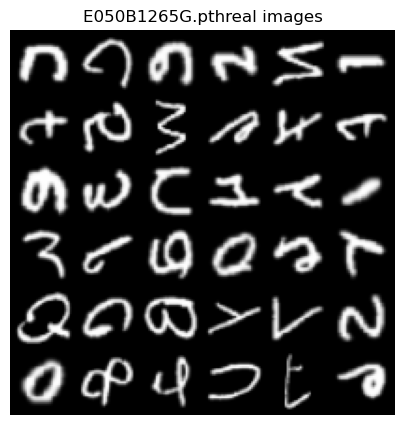

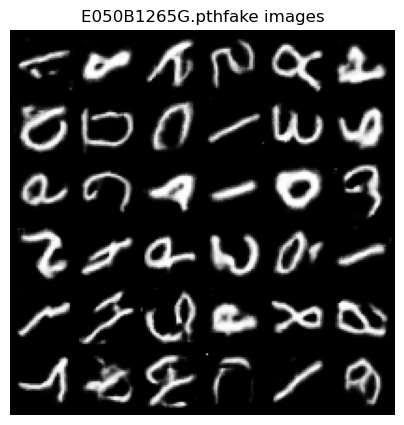

In [14]:
weights_root = './dcGAN_1/weights'
weight = 'E050B1265G.pth'
PATH = os.path.join(weights_root, weight)
for i, imgs in enumerate(dataloader):
    real_imgs = imgs.to(device)
    z = torch.randn(imgs.size(0), opt.latent_dim).to(device)
    generator.load_state_dict(torch.load(PATH))
    fake_imgs = generator(z)

    show_images(real_imgs, fake_imgs, save=True, name=weight)
    break